# Setup

In this example script, we create a mock model that convolves the input waveform by 7 causal filters emulating gamma distribution probability density functions, with different theoretical integration windows specified by the $\text{rate}$ parameter.

Since we know the filters, we can estimate the integration windows directly from the cumulative density function of the gamma distributions. Here, we approximate the integration window by measuring how long it takes for the area under the curve of each filter to reach 90% of its maximum value.

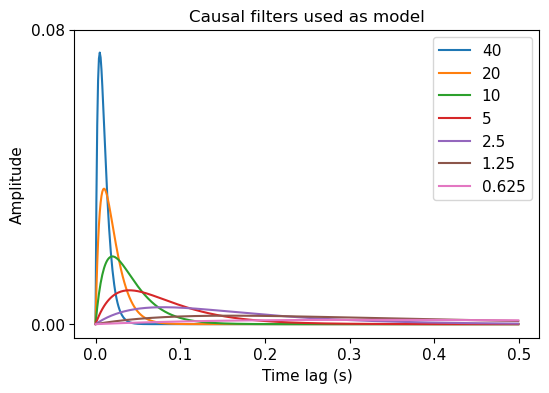

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

import PyTCI

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Different rates for the filter
rates = [40, 20, 10, 5, 2.5, 1.25, 0.625]

# Create filters gamma distributions
weights = []
for rate in rates:
    dist = torch.distributions.gamma.Gamma(2, rate)
    dist = torch.tensor([torch.exp(dist.log_prob(i)) for i in np.arange(1e-4, 10, 0.005)])
    weights.append(dist.flip(0) / sum(dist))
weights = torch.stack(weights, dim=0).unsqueeze(dim=1).to(device).float()

# Create mock model that applies above filters to input
def model(x):
    x = torch.as_tensor(x, device=device)
    x = torch.nn.functional.pad(x, (0, 0, weights.shape[-1]-1, 0)).float()
    x = x.T.unsqueeze(dim=0)
    x = torch.nn.functional.conv1d(x, weights)
    x = x.squeeze(dim=0).T
    
    return x

# Estimate integration windows directly from filter windows
cdf = weights.squeeze(1).cumsum(axis=1).cpu()
intwin_cdf = [(np.where(c.flip(0) >= 0.10)[0][-1])/1000+0.001 for c in cdf]

# Create 1000 random 5-second segments with sampling rate of 1000
sr = 1000
segments = [torch.randn(5000, 1) for i in range(1000)]

# Plot the gamma distribution filters
plt.figure(figsize=(6, 4))
plt.plot(np.arange(500)/1000, weights.squeeze(1).T.flip(0)[:500].cpu(), linewidth=1.5)
plt.xlabel('Time lag (s)', fontsize=11)
plt.ylabel('Amplitude', fontsize=11)
plt.title('Causal filters used as model', fontsize=12)
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=11)
plt.yticks([0, 0.08], fontsize=11)
plt.legend(rates, loc='upper right', fontsize=11)
plt.show()

# Basic usage

The base class of the $\text{PyTCI}$ package is $\text{Analyzer}$. This class is used to estimate the integration window of a blackbox model. The model does not need to be differentiable, as long as we can get its response to input sequences generated by the $\text{Analyzer}$ object, determined by the TCI paradigm.

The most simple usage of the class is by specifying the response sampling rate $\text{out_sr}$ and a model for inferring responses to input sequences generated by $\text{Analyzer}$, setting the source segments to generate the sequences from, and running $\text{estimate_integration_window}$.

When providing a model to $\text{Analyzer}$, it should take input of shape \[$\text{time}_{in} \times \text{channels}_{in}$\] and return response of shape \[$\text{time}_{out} \times \text{channels}_{out}$\].

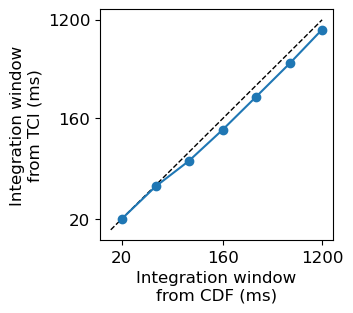

In [2]:
# Setup TCI analyzer
analyzer = PyTCI.Analyzer(out_sr=1000, model=model, threshold=0.95, verbose=0)

# Feed list of source segments to analyzer
analyzer.set_segments(segments, sr=1000)

# Estimate integration periods using TCI paradigm
intwin_tci = analyzer.estimate_integration_window()

# Compare results
plt.figure(figsize=(3, 3))
plt.plot(np.log([0.016, 1.2]), np.log([0.016, 1.2]), 'k--', linewidth=1)
plt.plot(
    np.log(intwin_cdf),
    np.log(intwin_tci),
    '-o'
)
plt.xticks(np.log([0.02, 0.16, 1.2]), [20, 160, 1200], fontsize=12)
plt.yticks(np.log([0.02, 0.16, 1.2]), [20, 160, 1200], fontsize=12)
plt.xlabel('Integration window\nfrom CDF (ms)', fontsize=12)
plt.ylabel('Integration window\nfrom TCI (ms)', fontsize=12)
plt.show()

# Loading segments from files

Sources segments can also be loaded from the disk, by specifying a list of file paths, or the path to a directory which contains all the segments. The files can be in several formats, including audio, numpy, or pytorch. If in numpy or pytorch format, the input should be a pair ($\text{segment}$, $\text{sampling_rate}$), where the segment has shape \[$\text{time} \times \text{channels}$\] and $\text{sampling_rate}$ is an integer.

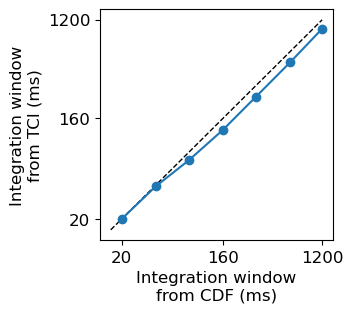

In [3]:
# Save segments to file
os.makedirs('resources', exist_ok=True)
os.makedirs('resources/segments-random-1k', exist_ok=True)
for i, segment in enumerate(segments):
    np.save(
        f'resources/segments-random-1k/segment_{i:03d}.npy',
        np.array((segment.numpy(), sr), dtype=object)
    )

# Setup TCI analyzer
analyzer = PyTCI.Analyzer(out_sr=1000, model=model, threshold=0.95, verbose=0)

# Load source segments from disk
analyzer.load_segments('resources/segments-random-1k/', fmt='numpy')

# Estimate integration periods using TCI paradigm
intwin_tci = analyzer.estimate_integration_window()

# Compare results
plt.figure(figsize=(3, 3))
plt.plot(np.log([0.016, 1.2]), np.log([0.016, 1.2]), 'k--', linewidth=1)
plt.plot(
    np.log(intwin_cdf),
    np.log(intwin_tci),
    '-o'
)
plt.xticks(np.log([0.02, 0.16, 1.2]), [20, 160, 1200], fontsize=12)
plt.yticks(np.log([0.02, 0.16, 1.2]), [20, 160, 1200], fontsize=12)
plt.xlabel('Integration window\nfrom CDF (ms)', fontsize=12)
plt.ylabel('Integration window\nfrom TCI (ms)', fontsize=12)
plt.show()

# Manual inference

In cases where the model can not be conveniently expressed as a python function as described above, or when planning to analyze a large batch of models without regenrating the TCI sequences every time, we can use the manual inference feature.

There are two key functions used to achieve this:
1. $\text{write_sequences}$: generates two TCI sequences ($\text{seq_A}$ and $\text{seq_B}$) for each segment duration, and stores the resulting sequences in individual files in the specified directory. Several formats are supported for writing the sequences, including audio, numpy, and torch.
2. $\text{read_responses}$: reads the responses ($\text{resp_A}$, $\text{resp_B}$) to all sequences inferred by the model and saved to disk, following a similar format. 

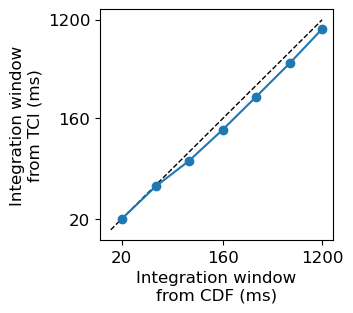

In [4]:
# Setup TCI analyzer
analyzer = PyTCI.Analyzer(out_sr=1000, threshold=0.95, verbose=0)

# Feed list of source segments to analyzer
analyzer.set_segments(segments, sr=1000)

# Generate two TCI sequences seq_A and seq_B and write them to disk
analyzer.write_sequences('outputs/manual-seq', fmt='numpy')

# Read sequences from disk, infer responses of the model, and write the two
# response sequences to disk
os.makedirs('outputs', exist_ok=True)
os.makedirs('outputs/manual-resp', exist_ok=True)
for segdur in analyzer.segment_durs:
    seq_A = np.load(f'outputs/manual-seq/seq_A_{round(segdur*1000)}ms.npy')
    resp_A = model(seq_A)
    np.save(f'outputs/manual-resp/resp_A_{round(segdur*1000)}ms.npy', resp_A.cpu())
    
    seq_B = np.load(f'outputs/manual-seq/seq_B_{round(segdur*1000)}ms.npy')
    resp_B = model(seq_B)
    np.save(f'outputs/manual-resp/resp_B_{round(segdur*1000)}ms.npy', resp_B.cpu())

# Read responses to both TCI sequences from disk
analyzer.read_responses('outputs/manual-resp', fmt='numpy')

# Estimate integration periods using TCI paradigm
intwin_tci = analyzer.estimate_integration_window()

# Compare results
plt.figure(figsize=(3, 3))
plt.plot(np.log([0.016, 1.2]), np.log([0.016, 1.2]), 'k--', linewidth=1)
plt.plot(
    np.log(intwin_cdf),
    np.log(intwin_tci),
    '-o'
)
plt.xticks(np.log([0.02, 0.16, 1.2]), [20, 160, 1200], fontsize=12)
plt.yticks(np.log([0.02, 0.16, 1.2]), [20, 160, 1200], fontsize=12)
plt.xlabel('Integration window\nfrom CDF (ms)', fontsize=12)
plt.ylabel('Integration window\nfrom TCI (ms)', fontsize=12)
plt.show()

# Preprocessing

It is possible to manipulate the input segments before generating the TCI sequences, using the $\text{preprocess}$ parameter of $\text{set_segments}$ or $\text{load_segments}$. This is mainly useful in two cases:
1. When loading segments from the disk, but we don't want to make changes to the files on disk.
2. When comparing the effects of specific stimulus manipulations on integration windows of the model.

The $\text{preprocess}$ parameter takes in a function or an ordered list of functions, that will be applied to each segment in series, before generating the TCI sequences. There are a number of basic preprocessing functions provided in the <a href="https://github.com/naplab/PyTCI/blob/main/PyTCI/preprocessing.py">$\text{preprocessing}$</a> module, mostly for manipulating audio waveforms.

Here, we try a couple of examples. Note that since the mock model we defined at the beginning of this script has a fixed window size determined by the $\text{rate}$ parameter of the gamma distributions, the stimulus manipulations do not alter the estimations for the integration windows.

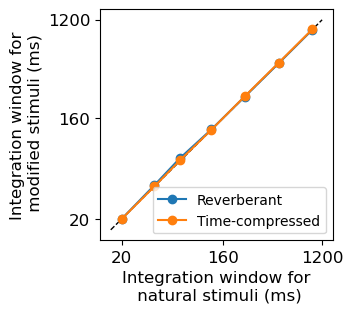

In [5]:
# Estimate integration periods for original inputs
analyzer = PyTCI.Analyzer(out_sr=1000, model=model, threshold=0.95, verbose=0)
analyzer.set_segments(
    segments, sr=1000
)
intwin_norm = analyzer.estimate_integration_window()

# Estimate integration periods for reverberant inptus
analyzer = PyTCI.Analyzer(out_sr=1000, model=model, threshold=0.95, verbose=0)
analyzer.set_segments(
    segments, sr=1000,
    preprocess=PyTCI.preprocessing.audio_reverb_fx(reverberance=20, room_scale=70)
)
intwin_revb = analyzer.estimate_integration_window()

# Estimate integration periods for time-compressed inputs
analyzer = PyTCI.Analyzer(out_sr=1000, model=model, threshold=0.95, verbose=0)
analyzer.set_segments(
    segments, sr=1000,
    preprocess=PyTCI.preprocessing.audio_speed_fx(scale_factor=1.25)
)
intwin_fast = analyzer.estimate_integration_window()

# Compare results
plt.figure(figsize=(3, 3))
plt.plot(np.log([0.016, 1.2]), np.log([0.016, 1.2]), 'k--', linewidth=1)
plt.plot(
    np.log(intwin_norm),
    np.log(intwin_revb),
    '-o', label='Reverberant'
)
plt.plot(
    np.log(intwin_norm),
    np.log(intwin_fast),
    '-o', label='Time-compressed'
)
plt.xticks(np.log([0.02, 0.16, 1.2]), [20, 160, 1200], fontsize=12)
plt.yticks(np.log([0.02, 0.16, 1.2]), [20, 160, 1200], fontsize=12)
plt.xlabel('Integration window for\n natural stimuli (ms)', fontsize=12)
plt.ylabel('Integration window for\n modified stimuli (ms)', fontsize=12)
plt.legend()
plt.show()

# Natural-random vs. random-random

There are two methods for generating the two TCI sequences, as described in the paper:
1. Random-random: both sequences are created by random ordering of the segments.
2. Natural-random: one sequence is created by having the segments in their natural context (determined by the $\text{segment_maxdur}$ parameter of the $\text{Analyzer}$ object), while the other is the result of a random ordering like in the previous case.

The default behavior is "random-random". To change the method to "natural-random", set the $\text{comparison_method}$ parameter of $\text{Analyzer}$ to $\text{'natural-random'}$.

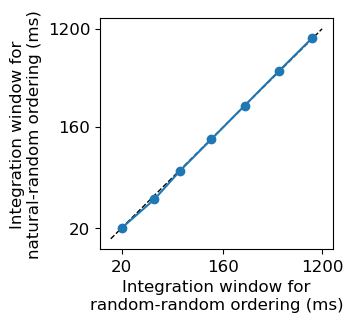

In [6]:
# Estimate integration periods using the random-random paradigm
analyzer = PyTCI.Analyzer(
    out_sr=1000, model=model,
    comparison_method='random-random', threshold=0.95, verbose=0
)
analyzer.set_segments(
    segments, sr=1000
)
intwin_rr = analyzer.estimate_integration_window()

# Estimate integration periods using the natural-random paradigm
analyzer = PyTCI.Analyzer(
    out_sr=1000, model=model,
    comparison_method='natural-random', threshold=0.95, verbose=0)
analyzer.set_segments(
    segments, sr=1000, preprocess=PyTCI.preprocessing.audio_speed_fx(scale_factor=1.2)
)
intwin_nr = analyzer.estimate_integration_window()

# Compare results
plt.figure(figsize=(3, 3))
plt.plot(np.log([0.016, 1.2]), np.log([0.016, 1.2]), 'k--', linewidth=1)
plt.plot(
    np.log(intwin_rr),
    np.log(intwin_nr),
    '-o'
)
plt.xticks(np.log([0.02, 0.16, 1.2]), [20, 160, 1200], fontsize=12)
plt.yticks(np.log([0.02, 0.16, 1.2]), [20, 160, 1200], fontsize=12)
plt.xlabel('Integration window for\nrandom-random ordering (ms)', fontsize=12)
plt.ylabel('Integration window for\nnatural-random ordering (ms)', fontsize=12)
plt.show()